In [1]:
# IMPORTS
import pandas as pd

import pandas_datareader as pdr
from datetime import date

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from io import StringIO

## Financial Indicator

There are two main types of indicators:
1. [Macroeconomics indicators for stock markets](https://pythoninvest.com/long-read/macro-indicators-affecting-stock-market)
2. Market Indicators

In [2]:
end = date.today()
print(f"Today is Year = {end.year}; month = {end.month}; day = {end.day}")

# Pull back 70 years of data
start = date(year=end.year-70, month=end.month, day=end.day)
print(f"Period for indexes: {start} to {end}")

Today is Year = 2024; month = 4; day = 21
Period for indexes: 1954-04-21 to 2024-04-21


In [3]:
# Time-series plot
def ts_plot(df, ts_column, sts_column, ts_label, sts_label, datetime_label="Date"):
    """
    Plot time-series associated with its growth in percentage on secondary y-axis.
    Reference: https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/
    """
    fig, ax = plt.subplots(figsize=(20, 6))
    plt.grid(True)

    ax.fill_between(df.index, df[ts_column], color="red", alpha=0.3, label=ts_label)

    sax = ax.twinx()
    sax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    sax.plot(df[sts_column], color="blue", marker="o", label=sts_label)

    ax.set_xlabel(datetime_label, fontsize=14)
    ax.set_ylabel(ts_label, fontsize=14)
    sax.set_ylabel(sts_label, fontsize=14)

    lines, labels = ax.get_legend_handles_labels()
    slines, slabels = sax.get_legend_handles_labels()
    sax.legend(lines + slines, labels + slabels, loc="upper left")

    plt.show()

### Gross Domestic Product (GDP)

GDP signifies the total amount of economic activities. For the US, we will use [*Real Potential Gross Domestic Product (GDPPOT)*](https://fred.stlouisfed.org/series/GDPPOT) from *Fred* pulling via `pandas-datareader`.

Note that *GDPPOT* will be available quarterly and in the unit of billions of Chained 2017 Dollars.

In [4]:
gdppot_df = pdr.DataReader("GDPPOT", "fred", start=start)

# GDP Growth Calculation
gdppot_df["GDP_GROWTH_YOY"] = gdppot_df["GDPPOT"] / gdppot_df["GDPPOT"].shift(4) - 1
gdppot_df["GDP_GROWTH_QOQ"] = gdppot_df["GDPPOT"] / gdppot_df["GDPPOT"].shift(1) - 1

In [5]:
gdppot_df

,GDPPOT,GDP_GROWTH_YOY,GDP_GROWTH_QOQ
DATE,,,
1954-07-01,2922.682483,NaN,NaN
1954-10-01,2941.203176,NaN,0.006337
1955-01-01,2959.166643,NaN,0.006108
1955-04-01,2978.435270,NaN,0.006512
1955-07-01,2997.302681,0.025531,0.006335
...,...,...,...
2023-04-01,22246.230000,0.021312,0.005442
2023-07-01,22369.710000,0.021719,0.005551
2023-10-01,22495.190000,0.022190,0.005609


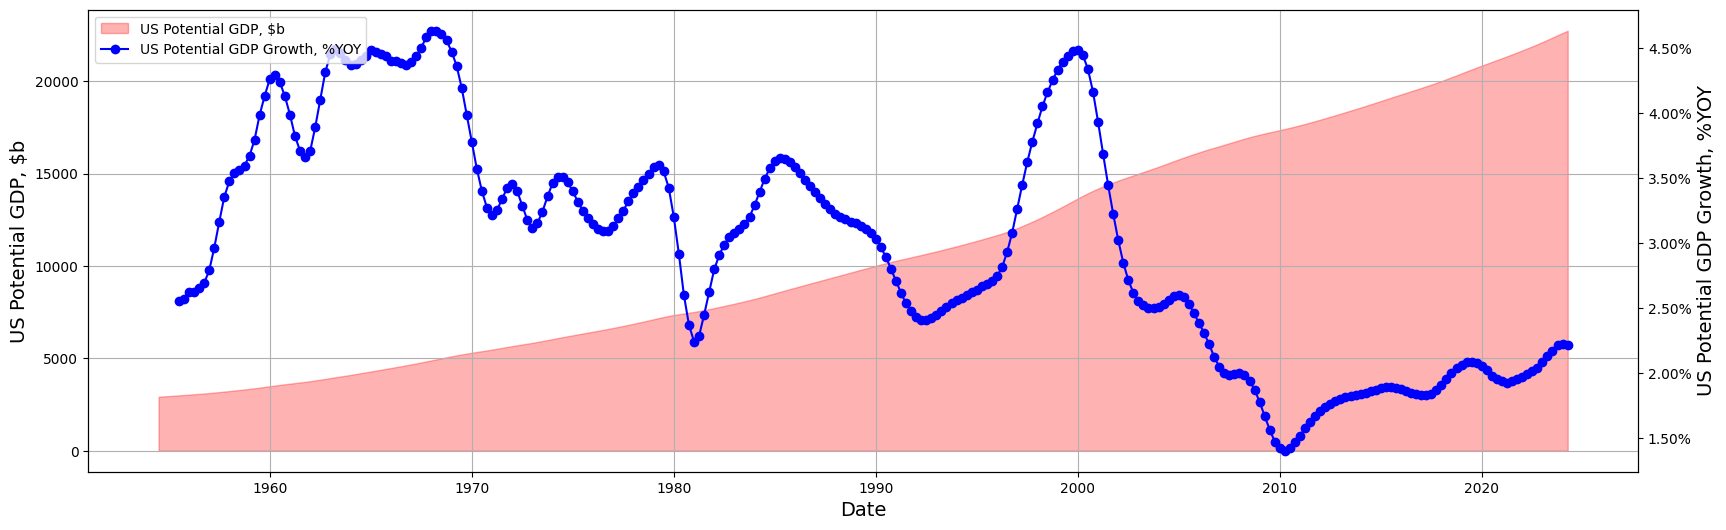

In [6]:
# Visualize GDPPOT
ts_plot(gdppot_df, ts_column="GDPPOT", sts_column="GDP_GROWTH_YOY", ts_label="US Potential GDP, $b", sts_label="US Potential GDP Growth, %YOY")

As you can see from the plot, the total value of economic activities should be accumulated over long period of time. This shows the whole country can contribute work or values to the economy. However, in some year its growth can drop. 

*GDP Growth* is a good indicator to measure your investment whether you have the ability to produce growth compared to GDP.

### Consumer Price Index (CPI) - Core Inflation

CPI is an aggregate of prices paid by urban consumers for a typical basket of goods excluding food and energy as these prices have very volatile prices. For the US, we will use [*Core CPI index*](https://fred.stlouisfed.org/series/CPILFESL) from *Fred* pulling via `pandas-datareader`.

Note that *Core CPI index* will be available on a monthly basis and since it is an index, no unit of measurement.

In [7]:
cpi_df = pdr.DataReader("CPILFESL", "fred", start=start)

# CPI Growth Calculation
cpi_df["CPI_GROWTH_YOY"] = cpi_df["CPILFESL"] / cpi_df["CPILFESL"].shift(12) - 1
cpi_df["CPI_GROWTH_MOM"] = cpi_df["CPILFESL"] / cpi_df["CPILFESL"].shift(1) - 1

In [8]:
cpi_df

,CPILFESL,CPI_GROWTH_YOY,CPI_GROWTH_MOM
DATE,,,
1957-01-01,28.500,NaN,NaN
1957-02-01,28.600,NaN,0.003509
1957-03-01,28.700,NaN,0.003497
1957-04-01,28.800,NaN,0.003484
1957-05-01,28.800,NaN,0.000000
...,...,...,...
2023-11-01,312.349,0.040151,0.003080
2023-12-01,313.209,0.039101,0.002753
2024-01-01,314.438,0.038747,0.003924


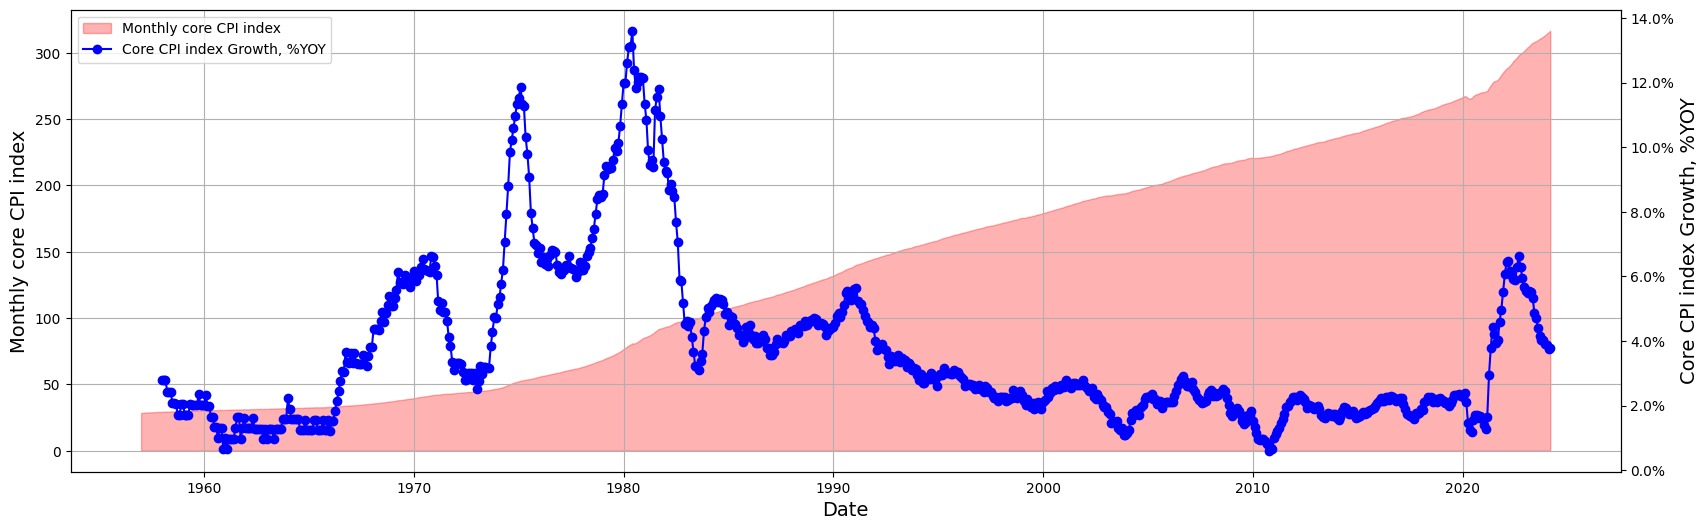

In [9]:
# Visualize CPI
ts_plot(cpi_df, ts_column="CPILFESL", sts_column="CPI_GROWTH_YOY", ts_label="Monthly core CPI index", sts_label="Core CPI index Growth, %YOY")

From the visualization, inflation should increase in the long run. For the US, CPI Growth should be around 3-4%.

Note that *Core CPI Growth* affects the expected return in your investment.

### FED Rate - FEDFUNDS

FED rate is a base interest rate from FED. Many interest rates in the market refer to this rate for their own calculation. For the US, we will use [*FEDFUNDS Rate*](https://fred.stlouisfed.org/series/FEDFUNDS) from *Fred* pulling via `pandas-datareader`.

Note that *Fed rate* will be available on a daily basis.

In [10]:
fed_rate_df = pdr.DataReader("FEDFUNDS", "fred", start=start)

# Resample to quarterly FED rate in order to plot along with GDPPOT
fed_rate_df = fed_rate_df.resample("QS").mean()
fed_rate_df["FEDFUNDS"] = fed_rate_df["FEDFUNDS"] / 100
fed_rate_df = fed_rate_df.join(gdppot_df)

In [11]:
fed_rate_df

,FEDFUNDS,GDPPOT,GDP_GROWTH_YOY,GDP_GROWTH_QOQ
DATE,,,,
1954-07-01,0.010300,2922.682483,NaN,NaN
1954-10-01,0.009867,2941.203176,NaN,0.006337
1955-01-01,0.013433,2959.166643,NaN,0.006108
1955-04-01,0.015000,2978.435270,NaN,0.006512
1955-07-01,0.019400,2997.302681,0.025531,0.006335
...,...,...,...,...
2023-01-01,0.045167,22125.820000,0.020847,0.005405
2023-04-01,0.049900,22246.230000,0.021312,0.005442
2023-07-01,0.052600,22369.710000,0.021719,0.005551


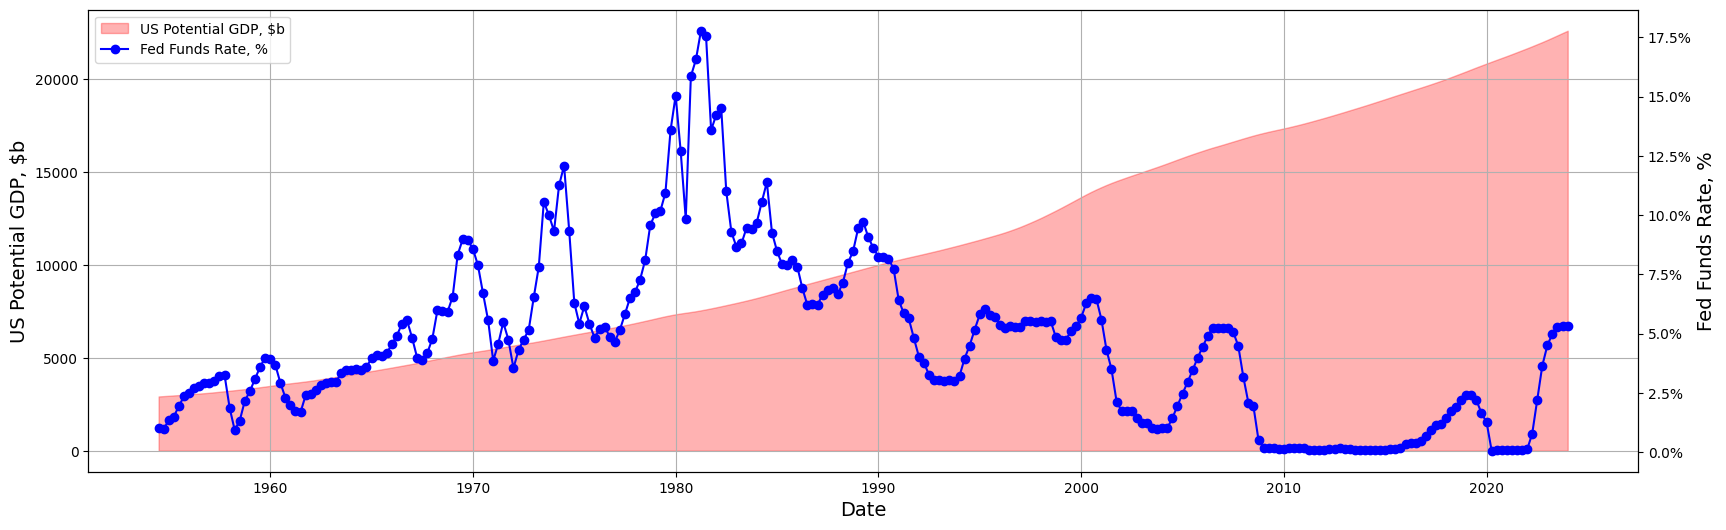

In [12]:
# Visualize FED rate with GDPPOT
ts_plot(fed_rate_df, ts_column="GDPPOT", sts_column="FEDFUNDS", ts_label="US Potential GDP, $b", sts_label="Fed Funds Rate, %")

Note that the higher interest rate, the more cost of investment is required. Typical FED rate is usually around 5-7%.

There are other metrices for interest rate such as [US treasury](https://fred.stlouisfed.org/categories/115) categorized by maturity.
* [2-Year Constant Maturiy](https://fred.stlouisfed.org/series/DGS2)
* [3-Year Constant Maturiy](https://fred.stlouisfed.org/series/DGS3)
* [5-Year Constant Maturiy](https://fred.stlouisfed.org/series/DGS5)
* [10-Year Constant Maturiy](https://fred.stlouisfed.org/series/DGS10)

### S&P500 (SPX)

It is a stock market index which shows the whole market capitalization. For Thai market, it is *SET*. We can download stock index data from [*stooq*](https://stooq.com/t/) via `pandas-datareader`.

As it is a stock market index, price will be available on a daily basis and consists of OHLCV data. Also, there is no unit of measurement, since it is an index.

In [ ]:
# SPX = S&P500
spx_df = pdr.get_data_stooq('^SPX', start, end)

# Relative growth calculated based on 252 trading days; data is in reverse order
spx_df["SPX_CHANGES_DOD"] = spx_df["Close"] / spx_df["Close"].shift(-1) - 1
spx_df["SPX_CHANGES_QOQ"] = spx_df["Close"] / spx_df["Close"].shift(-63) - 1
spx_df["SPX_CHANGES_YOY"] = spx_df["Close"] / spx_df["Close"].shift(-252) - 1

# Using data since 1990
spx_df = spx_df[spx_df.index >= "1990-01-01"]

In [ ]:
spx_df

,Open,High,Low,Close,Volume,SPX_CHANGES_DOD,SPX_CHANGES_QOQ,SPX_CHANGES_YOY
Date,,,,,,,,
2024-04-19,5005.44,5019.02,4953.56,4967.23,2.727319e+09,-0.008759,0.026327,0.195621
2024-04-18,5031.52,5056.66,5001.89,5011.12,2.217369e+09,-0.002208,0.048145,0.206083
2024-04-17,5068.97,5077.96,5007.25,5022.21,2.295628e+09,-0.005781,0.059715,0.209786
2024-04-16,5064.59,5079.84,5039.83,5051.41,2.347350e+09,-0.002057,0.059889,0.220843
2024-04-15,5149.67,5168.43,5052.47,5061.82,2.319452e+09,-0.012021,0.058110,0.220828
...,...,...,...,...,...,...,...,...
1990-01-08,352.20,354.24,350.54,353.79,7.783889e+07,0.004514,-0.013908,0.259129
1990-01-05,355.67,355.67,351.35,352.20,8.807222e+07,-0.009756,-0.013362,0.254854
1990-01-04,358.76,358.76,352.89,355.67,9.833333e+07,-0.008613,-0.003558,0.270205


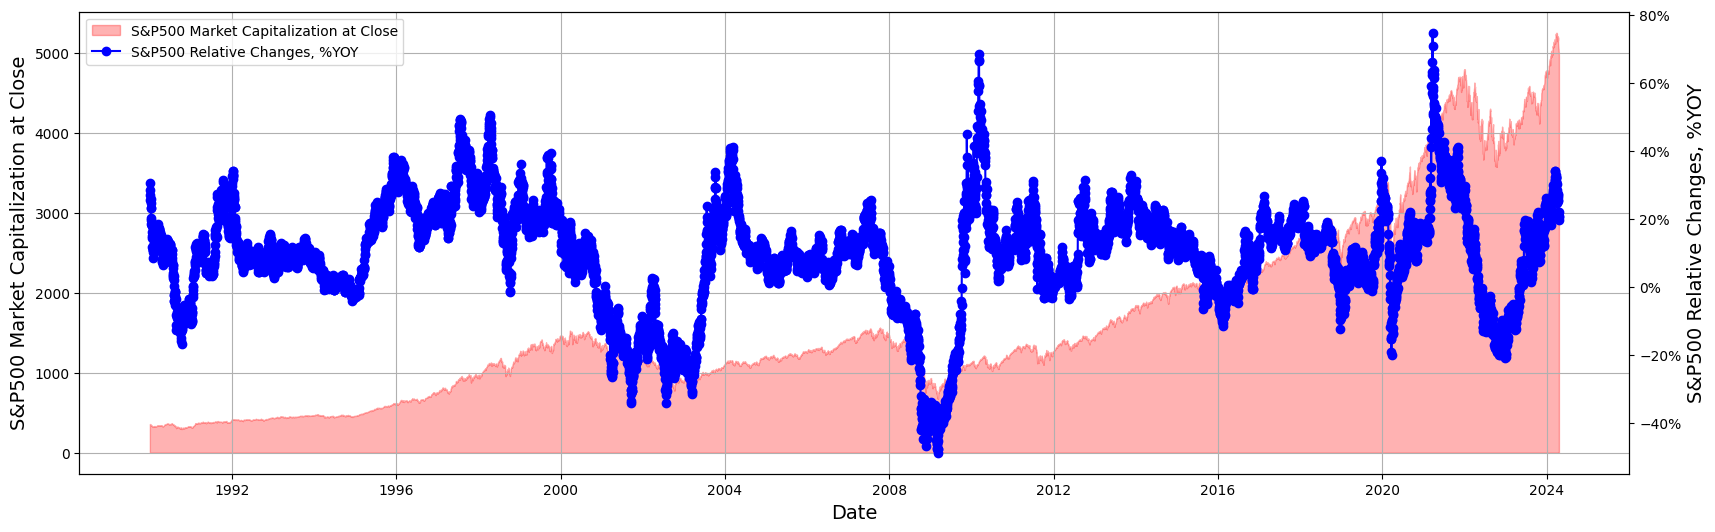

In [ ]:
# Visualize S&P500
ts_plot(spx_df, ts_column="Close", sts_column="SPX_CHANGES_YOY", ts_label="S&P500 Market Capitalization at Close", sts_label="S&P500 Relative Changes, %YOY")

A stock index like S&P500 is a benchmark for your investment whether you can do better than passive investing.

## Data Sources

### Tradingview - Stock Screener

UI interface for simple heuristic. For example, in S&P500, Query a stock with **Dividended Yield > 2%**, **Revenue Growth, %YOY > 25%** and **PEG < 0.5**. This can reduce the number of feasible stocks for downstream analysis.

### Yahoo Finance

There are a lot of free data available in `yfinance`:

* OHLCV data on different asset classes (indexes, bonds, etfs, crypto and currencies) and different interval periods (daily, hourly, 1-minute).
* Corporate actions such as stock splits and dividends.
* Financial report from the latest 4 years.

Reference: [Everything you need to know about yfinance](https://zoo.cs.yale.edu/classes/cs458/lectures/yfinance.html)

#### OHLCV daily data - INDEXES

In [13]:
# Top 40 largest german companies on Frankfurt Stock Exchange
dax_df = yf.download(tickers="^GDAXI", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [14]:
dax_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1987-12-30,1005.190002,1005.190002,1005.190002,1005.190002,1005.190002,0
1988-01-04,956.489990,956.489990,956.489990,956.489990,956.489990,0
1988-01-05,996.099976,996.099976,996.099976,996.099976,996.099976,0
1988-01-06,1006.010010,1006.010010,1006.010010,1006.010010,1006.010010,0
1988-01-07,1014.469971,1014.469971,1014.469971,1014.469971,1014.469971,0
...,...,...,...,...,...,...
2024-04-15,17937.619141,18191.949219,17937.619141,18026.580078,18026.580078,65138500
2024-04-16,18022.169922,18022.689453,17713.500000,17766.230469,17766.230469,73217300
2024-04-17,17764.029297,17907.580078,17731.789062,17770.019531,17770.019531,55970700


In [15]:
# S&P500 (SPX): Chicago options - 15-min delayed price
# https://finance.yahoo.com/quote/%5ESPX/
spx_df = yf.download(tickers="^SPX", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [16]:
spx_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...,...
2024-04-15,5149.669922,5168.430176,5052.470215,5061.819824,5061.819824,3950210000
2024-04-16,5064.589844,5079.839844,5039.830078,5051.410156,5051.410156,4006200000
2024-04-17,5068.970215,5077.959961,5007.250000,5022.209961,5022.209961,3596130000


In [17]:
# S&P500 (SNP): Real-time price
# https://finance.yahoo.com/quote/%5EGSPC/
snp_df = yf.download(tickers="^GSPC", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [18]:
snp_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...,...
2024-04-15,5149.669922,5168.430176,5052.470215,5061.819824,5061.819824,3950210000
2024-04-16,5064.589844,5079.839844,5039.830078,5051.410156,5051.410156,4006200000
2024-04-17,5068.970215,5077.959961,5007.250000,5022.209961,5022.209961,3596130000


In [19]:
# Dow Jones Industrial Average (DJI)
# https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch
dji_df = yf.download(tickers="^DJI", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [20]:
dji_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1992-01-02,3152.100098,3172.629883,3139.310059,3172.399902,3172.399902,23550000
1992-01-03,3172.399902,3210.639893,3165.919922,3201.500000,3201.500000,23620000
1992-01-06,3201.500000,3213.330078,3191.860107,3200.100098,3200.100098,27280000
1992-01-07,3200.100098,3210.199951,3184.479980,3204.800049,3204.800049,25510000
1992-01-08,3204.800049,3229.199951,3185.820068,3203.899902,3203.899902,29040000
...,...,...,...,...,...,...
2024-04-15,38075.378906,38386.808594,37657.789062,37735.109375,37735.109375,389170000
2024-04-16,37992.218750,37992.218750,37713.699219,37798.968750,37798.968750,339480000
2024-04-17,37949.671875,38036.699219,37611.558594,37753.308594,37753.308594,314650000


In [21]:
# SET Index (SET)
# https://finance.yahoo.com/quote/%5ESET.BK?.tsrc=fin-srch
set_df = yf.download(tickers="^SET.BK", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [22]:
set_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-12-11,890.549988,897.369995,879.510010,885.859985,885.859985,55400
1996-12-12,880.340027,880.340027,868.460022,872.250000,872.250000,49200
1996-12-13,864.400024,872.669983,857.549988,872.669983,872.669983,55500
1996-12-16,872.760010,873.010010,867.809998,872.760010,872.760010,43200
1996-12-17,872.179993,874.440002,861.460022,867.229980,867.229980,55200
...,...,...,...,...,...,...
2024-04-10,1404.030029,1411.459961,1402.890015,1408.170044,1408.170044,3970700
2024-04-11,1405.650024,1406.770020,1394.709961,1396.380005,1396.380005,3344200
2024-04-17,1378.040039,1380.119995,1363.439941,1366.939941,1366.939941,4499300


#### OHLCV daily data - ETFs

In [23]:
# WisdomTree India Earnings Fund (EPI): NYSEArca - Nasdaq real-time price
# https://finance.yahoo.com/quote/EPI/history?p=EPI
epi_df = yf.download(tickers="EPI", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [24]:
epi_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-02-26,25.920000,26.270000,25.700001,26.160000,21.503218,813800
2008-02-27,26.129999,26.270000,25.860001,26.070000,21.429239,881900
2008-02-28,25.980000,26.030001,25.660000,25.700001,21.125101,1037000
2008-02-29,25.330000,25.330000,24.730000,24.809999,20.393526,854700
2008-03-03,24.230000,24.330000,23.879999,24.139999,19.842800,610000
...,...,...,...,...,...,...
2024-04-15,44.259998,44.259998,43.860001,43.869999,43.869999,648800
2024-04-16,43.950001,44.000000,43.810001,43.900002,43.900002,782300
2024-04-17,43.980000,43.980000,43.750000,43.770000,43.770000,613600


In [25]:
# Dividends impact on Close and Adj. Close
# https://help.yahoo.com/kb/SLN28256.html#:~:text=Adjusted%20close%20is%20the%20closing,Security%20Prices%20(CRSP)%20standards
epi_df[(epi_df.index >="2022-06-23") & (epi_df.index <="2022-06-28")]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-23,31.129999,31.26,31.000000,31.200001,29.303230,607700
2022-06-24,29.549999,29.91,29.500000,29.900000,29.847267,387900
2022-06-27,29.799999,29.82,29.660000,29.709999,29.657600,225400
2022-06-28,29.709999,29.76,29.389999,29.420000,29.368114,466600


In [26]:
# Corporate action for EPI
epi = yf.Ticker("EPI")

# Full corporate actions
epi.get_actions()

# Only dividend
# epi.get_dividends()

,Dividends,Stock Splits,Capital Gains
Date,,,
2008-12-22 00:00:00-05:00,0.091,0.0,0.0
2009-03-23 00:00:00-04:00,0.007,0.0,0.0
2009-06-22 00:00:00-04:00,0.002,0.0,0.0
2009-09-21 00:00:00-04:00,0.045,0.0,0.0
2009-12-21 00:00:00-05:00,0.006,0.0,0.0
2010-06-28 00:00:00-04:00,0.065,0.0,0.0
2010-09-20 00:00:00-04:00,0.065,0.0,0.0
2010-12-22 00:00:00-05:00,0.013,0.0,0.0
2011-06-22 00:00:00-04:00,0.062,0.0,0.0


As you can see that corporate action on 2022-06-24 (Dividend about 1.845) affects the price on 2022-06-23 around 1.58 USD for open price and 1.3 USD for close price.

Note that there is an option for paid service that can offer real-time and high-quality data with greater accuracy and reliability. *Polygon.io* and *IEX Cloud* is also offer other types of paid services like [Polygon.io News API](https://polygon.io/docs/stocks/get_vx_reference_tickers__id__events) or [News API](https://newsapi.org/docs/get-started).

In the AI era, you can utilize LLMs for [financial news summarization](https://pythoninvest.com/long-read/chatgpt-api-for-financial-news-summarization) which you can perform [sentiment analysis](https://pythoninvest.com/long-read/sentiment-analysis-of-financial-news) to get a capital gain over good and bad news.

### Macroeconomics

Macroeconomics data provide big-picture into economic trends. There are many macroeconomics statistics that we can leverage:

* Financial market benchmarks: GDP, Inflation, FED rate and Unemployment rate
* Commodity benchmarks: Gold/Silver, Crude Oil and Real Estate Index

#### FRED

FRED provides data in the US and can be downloaded via `pandas-datareader` or `nasdaq-data-link`.

In [27]:
# Total reserves excluding Gold for China
# https://fred.stlouisfed.org/series/TRESEGCNM052N
gold_df = pdr.DataReader("TRESEGCNM052N", "fred", start=start)

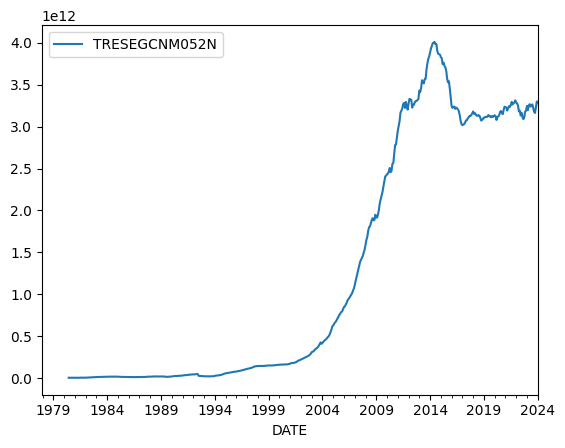

In [28]:
gold_df.plot()
plt.show()

In [29]:
#  CBOE Gold ETF Volatility Index (GVZCLS)
# https://fred.stlouisfed.org/series/GVZCLS
gold_volatility_df = pdr.DataReader("GVZCLS", "fred", start=start)

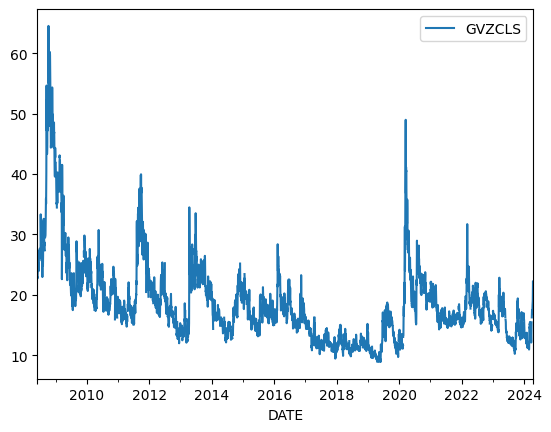

In [30]:
gold_volatility_df.plot()
plt.show()

In [31]:
#  Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma (DCOILWTICO)
# https://fred.stlouisfed.org/series/DCOILWTICO
wti_oil_df = pdr.DataReader("DCOILWTICO", "fred", start=start)

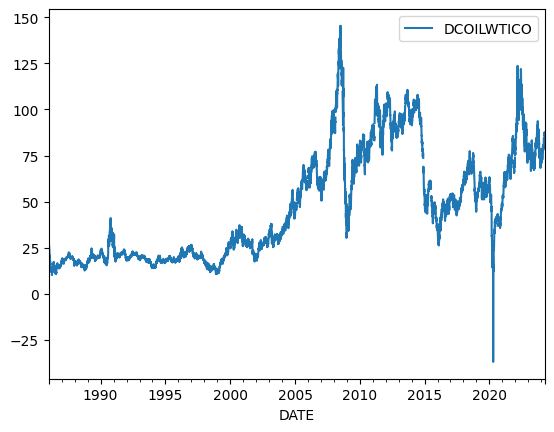

In [32]:
wti_oil_df.plot()
plt.show()

In [33]:
# Crude Oil Prices: Brent - Europe (DCOILBRENTEU)
# https://fred.stlouisfed.org/series/DCOILBRENTEU
brent_oil_df = pdr.DataReader("DCOILBRENTEU", "fred", start=start)

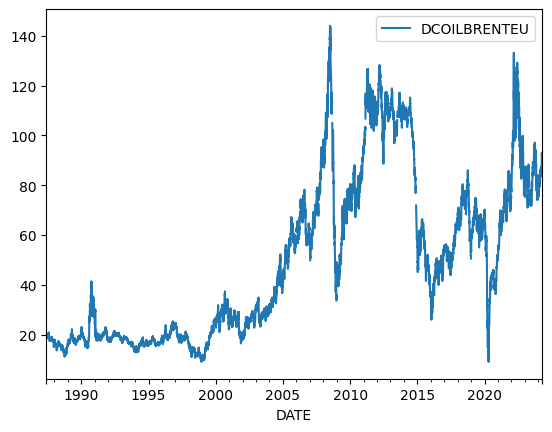

In [34]:
brent_oil_df.plot()
plt.show()

#### Trading Economics

[Trading Economics](https://tradingeconomics.com/indicators) offers indicators for other coutries not limited to the US. If you want to use its API, there is a paid option. Otherwise, you have to use web scraping or download files directly from its website.

Note that `pd.read_html()` can not be used directly as the website does not allow you to do it.

In [58]:
# Headers: User-Agent should be defined as to mimic the web browser behavior
url = "https://tradingeconomics.com/thailand/indicators"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

response = requests.get(url, headers=headers)
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    table = soup.find("table")

    trading_economics_df = pd.read_html(StringIO(str(table)))[0]
else:
    print("Failed to retrieve indicators!")

In [59]:
trading_economics_df

,Unnamed: 0,Last,Previous,Highest,Lowest,Unnamed: 5,Unnamed: 6
0,Currency,36.84,36.82,56.50,22.10,NaN,Apr/24
1,Stock Market,817.00,835.00,1224.00,135.00,points,Apr/24
2,GDP Growth Rate,-0.60,0.60,9.40,-9.20,percent,Dec/23
3,GDP Annual Growth Rate,1.70,1.40,15.50,-12.50,percent,Dec/23
4,Unemployment Rate,0.81,0.99,7.75,0.47,percent,Dec/23
5,Inflation Rate,-0.47,-0.77,24.56,-4.38,percent,Mar/24
6,Inflation Rate MoM,0.03,0.22,4.00,-3.00,percent,Mar/24
7,Interest Rate,2.50,2.50,5.00,0.50,percent,Apr/24
8,Balance of Trade,-554.00,-2758.00,4974.00,-5916.00,USD Million,Feb/24
9,Current Account,1965.00,-191.00,7162.00,-4086.00,USD Million,Feb/24


### Financial Report for public company - EDGAR

There are various sources that you can leverage *EDGAR* - millions of fillings to SEC:

* `python-edgar` is a free option read SEC fillings quarterly since 1993.
* `yfinance` also offers the financial report but limited to just yearly data for the last 4 years.
* `sec-api.io` offers a free/paid service for processing SEC fillings.

In [69]:
# yFinance
nvda = yf.Ticker("NVDA")

In [70]:
nvda.financials

,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Tax Effect Of Unusual Items,0.0,-284130000.0,0.0,0.0
Tax Rate For Calcs,0.12,0.21,0.019,0.017
Normalized EBITDA,35583000000.0,7340000000.0,11351000000.0,5691000000.0
Total Unusual Items,0.0,-1353000000.0,0.0,0.0
Total Unusual Items Excluding Goodwill,0.0,-1353000000.0,0.0,0.0
Net Income From Continuing Operation Net Minority Interest,29760000000.0,4368000000.0,9752000000.0,4332000000.0
Reconciled Depreciation,1508000000.0,1544000000.0,1174000000.0,1098000000.0
Reconciled Cost Of Revenue,16621000000.0,11618000000.0,9439000000.0,6279000000.0
EBITDA,35583000000.0,5987000000.0,11351000000.0,5691000000.0
EBIT,34075000000.0,4443000000.0,10177000000.0,4593000000.0


In [71]:
nvda.balance_sheet

,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Treasury Shares Number,NaN,NaN,NaN,1380000000.0
Ordinary Shares Number,2464000000.0,2466136572.0,2506000000.0,2480000000.0
Share Issued,2464000000.0,2466136572.0,2506000000.0,3860000000.0
Net Debt,2429000000.0,7564000000.0,8956000000.0,6116000000.0
Total Debt,11056000000.0,12031000000.0,11831000000.0,7597000000.0
...,...,...,...,...
Allowance For Doubtful Accounts Receivable,NaN,NaN,NaN,-21000000.0
Gross Accounts Receivable,NaN,NaN,NaN,2450000000.0
Cash Cash Equivalents And Short Term Investments,25984000000.0,13296000000.0,21208000000.0,11561000000.0
Other Short Term Investments,18704000000.0,9907000000.0,19218000000.0,10714000000.0


In [72]:
# nvda.basic_info
# Market capitialization is in $b
nvda.basic_info["marketCap"] / 1e9

1905.0

### Web Scraping - Company Information

In [24]:
# Headers: User-Agent should be defined as to mimic the web browser behavior
url = "https://companiesmarketcap.com/?download=csv"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

response = requests.get(url, headers=headers)
if response.status_code == 200:
    company_df = pd.read_csv(StringIO(str(response.content, "utf-8")))
else:
    print("Failed to retrieve company information!")

In [25]:
company_df

,Rank,Name,Symbol,marketcap,price (USD),country
0,1,Microsoft,MSFT,2965637169152,399.12,United States
1,2,Apple,AAPL,2547913326592,165.00,United States
2,3,Saudi Aramco,2222.SR,1929615470342,7.98,Saudi Arabia
3,4,Alphabet (Google),GOOG,1926240796672,155.72,United States
4,5,NVIDIA,NVDA,1905000054784,762.00,United States
...,...,...,...,...,...,...
8381,8382,Sberbank,SBER.ME,0,0.00,Russia
8382,8383,Gazprom,GAZP.ME,0,0.00,Russia
8383,8384,X5 Retail Group,FIVE.ME,0,0.00,Netherlands
8384,8385,United Heavy Machinery,OMZZP.ME,0,0.00,Russia


### Alternative Sources

* Trends & Social media: [Google Trends](https://hackernoon.com/how-to-use-google-trends-api-with-python) or Twitter.
* ETF Funds flow: [Renaissance Technologies Funds Flow](https://hedgefollow.com/funds/Renaissance+Technologies).

## Profitable Strategy

The profitable strategy is very simple. You need to do better than a benchmark. If not, you should only invest passively in an index fund. The criterion of a good profitable strategy should be as the following:

* Rolling positive return over time: roughly around 6 - 12 months
* Good portfolio management considering: risk-reward + time

### Rule of 72

It is a classic shortcut derived from the approximation of ln(2) / ln(1 + r) to estimate [how long it takes to double your investment](https://www.visualcapitalist.com/visualized-how-long-does-it-take-to-double-your-money/) given the rate of return - asset.

### Risk Profile

When you invest you have to consider other factors rather than the expected return - risk and time of investment. Therefore, it is important to evaluate your own [risk profile](https://www.ngpf.org/blog/investing/chart-explaining-investing-concept-risk-return/) and come up with the [portfolio optimization](https://pythoninvest.com/long-read/practical-portfolio-optimisation).